In [2]:
# imports
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from econml.dml import LinearDML
# from econml.dr import LinearDRLearner
from econml.drlearner import LinearDRLearner
from econml.cate_interpreter import SingleTreeCateInterpreter

from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# some features will be standardized
scaler = StandardScaler()

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [21]:
data_dir = '/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/'
plot_dir = '/Users/boyuliu/Dropbox (MIT)/Boyu-Joann/Intermediate output/plots/province_hte/'
wv_data_file = 'wv_cases1'

reg_data = pd.read_csv(data_dir + 'regression_data_wv_cases1_causal_ma_detrend_20210211.csv')
reg_data_notnull = reg_data.loc[pd.notnull(reg_data['demand_shock'])].reset_index()
reg_data.head()

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,demand_shock_minus_1,demand_shock_minus_2,demand_shock_minus_3,demand_shock_minus_4,demand_shock_minus_5,demand_shock_minus_6,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float,province_size
0,Ang Thong,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,NaN,0.000000,0.985677,-0.246419,-0.246419,-0.246419,1.232097,-0.369629,2018.02,4.044248
1,Ang Thong,2018-03,0.0,0.0,0.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,0.000000,0.985677,-0.246419,-0.246419,-0.246419,1.232097,-0.369629,-0.369629,2018.03,4.044248
2,Ang Thong,2018-04,0.0,0.0,0.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,0.985677,-0.246419,-0.246419,-0.246419,1.232097,-0.369629,-0.369629,-0.369629,2018.04,4.044248
3,Ang Thong,2018-05,10.0,0.0,0.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,-0.246419,-0.246419,-0.246419,1.232097,-0.369629,-0.369629,-0.369629,-0.369629,2018.05,4.044248
4,Ang Thong,2018-06,0.0,0.0,0.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,-0.246419,-0.246419,1.232097,-0.369629,-0.369629,-0.369629,-0.369629,0.000000,2018.06,4.044248


# province dummies only

In [13]:
x_columns = ['demand_shock']
y_column = 'perc_abuse'

# reg_data_notnull = reg_data.loc[pd.notnull(reg_data['demand_shock'])].reset_index()
province_dummies = pd.get_dummies(reg_data_notnull['province'])
X = reg_data_notnull[x_columns]
X = pd.concat([X, province_dummies], axis=1) 
print(X.shape)
# X = sm.add_constant(X)
Y = reg_data_notnull[y_column]

model = sm.OLS(Y, X, hasconst=False)
results = model.fit()
# results = model.fit(cov_type='cluster', cov_kwds=province_dummies.columns)
# print(results.summary())
print(results.get_robustcov_results().summary())
# # save results for summary table
# effect = results.params['treated']
# se = results.bse['treated']
# if print_summary:
#     print(results.summary())
# else:
#     print('treatment effect is %s, standard error is %s' % (effect, se))

(6438, 59)
                                 OLS Regression Results                                
Dep. Variable:             perc_abuse   R-squared (uncentered):                   0.188
Model:                            OLS   Adj. R-squared (uncentered):              0.180
Method:                 Least Squares   F-statistic:                              13.06
Date:                Wed, 10 Feb 2021   Prob (F-statistic):                   1.45e-116
Time:                        17:35:59   Log-Likelihood:                          1908.5
No. Observations:                6438   AIC:                                     -3699.
Df Residuals:                    6379   BIC:                                     -3300.
Df Model:                          59                                                  
Covariance Type:                  HC1                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------

# EconML province hte

In [14]:
X_test = pd.DataFrame(np.eye(province_dummies.shape[1]))
X_test.columns = province_dummies.columns
X_axis_labels = province_dummies.columns

In [15]:
x_columns = ['demand_shock']
y_column = 'perc_abuse'

W = pd.get_dummies(reg_data_notnull['province'])
X = W
T = reg_data_notnull[x_columns]
# X = pd.concat([X, province_dummies], axis=1) 
# X = sm.add_constant(X)
Y = reg_data_notnull[y_column]

est = LinearDML(model_t=RandomForestRegressor(min_samples_leaf=5),\
                model_y=RandomForestRegressor(min_samples_leaf=5), discrete_treatment=False)
est.fit(Y, T, X=X, W=W)
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)
# print summary
est.summary()

/usr/local/lib/python3.7/site-packages/econml/utilities.py:821: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
/usr/local/lib/python3.7/site-packages/econml/utilities.py:821: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/linear_model.py:1695: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,-0.001,0.004,-0.258,0.796,-0.008,0.006
X1,-0.027,0.018,-1.488,0.137,-0.057,0.003
X2,-0.002,0.004,-0.427,0.669,-0.008,0.005
X3,-0.006,0.017,-0.351,0.726,-0.033,0.021
X4,0.002,0.002,1.207,0.227,-0.001,0.005
X5,0.002,0.002,1.207,0.227,-0.001,0.005
X6,-0.004,0.007,-0.54,0.589,-0.015,0.008
X7,0.007,0.019,0.348,0.728,-0.025,0.038
X8,0.006,0.002,2.361,0.018,0.002,0.009
X9,-0.039,0.024,-1.586,0.113,-0.079,0.001


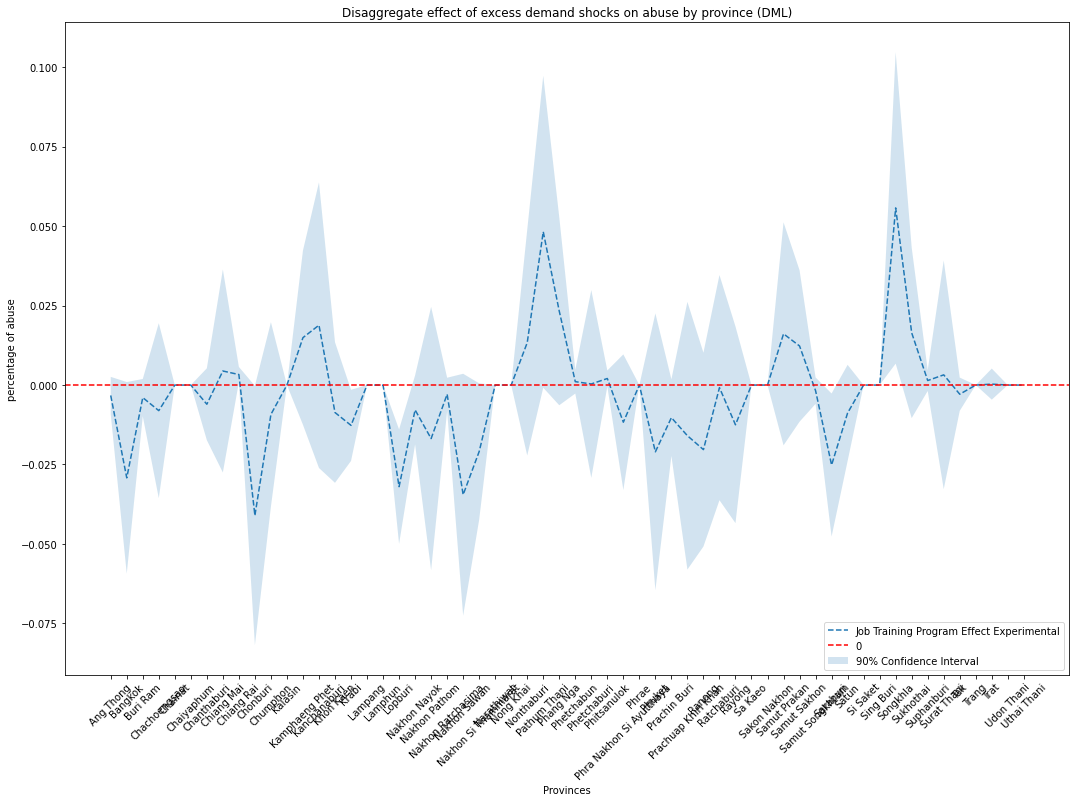

In [16]:
# Compare the estimate and the truth
plt.figure(figsize=(18, 12))
X_pos = np.arange(X_test.shape[0])
plt.plot(X_pos, te_pred, "--", label="Job Training Program Effect Experimental")
plt.xticks(X_pos, X_axis_labels, rotation=45)
plt.fill_between(
    X_pos,
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="90% Confidence Interval",
)
plt.axhline(c='red', ls='--', label='0')
plt.xlabel("Provinces")
plt.ylabel("percentage of abuse")
plt.title("Disaggregate effect of excess demand shocks on abuse by province (DML)")
plt.legend(loc="lower right")
plt.savefig(plot_dir+'dml_province_effect.png')
plt.show()

# OLS interaction hte plot (similar)

In [17]:
x_columns = ['demand_shock']
y_column = 'perc_abuse'

reg_data_notnull = reg_data.loc[pd.notnull(reg_data['demand_shock'])].reset_index()
province_dummies = pd.get_dummies(reg_data_notnull['province']).iloc[:,1:]
interaction_terms = pd.DataFrame(province_dummies.values * reg_data_notnull[x_columns].values)
interaction_terms.columns = [prov.replace(' ', '_')+'_beta' for prov in province_dummies.columns]
X = reg_data_notnull[x_columns]
X = pd.concat([X, province_dummies, interaction_terms], axis=1) 
X = sm.add_constant(X)
Y = reg_data_notnull[y_column]

model = sm.OLS(Y, X, hasconst=True)
results = model.fit()
robust_result = results.get_robustcov_results()
result_params = robust_result.params
conf_int = robust_result.conf_int()
result_names = robust_result.model.exog_names
# print(results.summary())
print(robust_result.summary())

                            OLS Regression Results                            
Dep. Variable:             perc_abuse   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     9.108
Date:                Wed, 10 Feb 2021   Prob (F-statistic):          2.84e-105
Time:                        17:37:35   Log-Likelihood:                 1934.2
No. Observations:                6438   AIC:                            -3636.
Df Residuals:                    6322   BIC:                            -2851.
Df Model:                         115                                         
Covariance Type:                  HC1                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2608: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 115, but rank is 86
  'rank is %d' % (J, J_), ValueWarning)


In [18]:
location_angthong = 1
location_prov_interaction = [location_angthong]+[
        i for i in range(len(result_names)) if result_names[i].endswith('beta')]
names = ['Ang Thong']+[prov.strip('_beta') for prov in result_names if prov.endswith('beta')]
effects = result_params[location_prov_interaction]
conf_int_prov = conf_int[location_prov_interaction]
hte_data = pd.DataFrame({'names':names,
                        'effects':effects,
                        'CI lower':conf_int_prov[:,0],
                        'CI upper':conf_int_prov[:,1]})
# hte_data

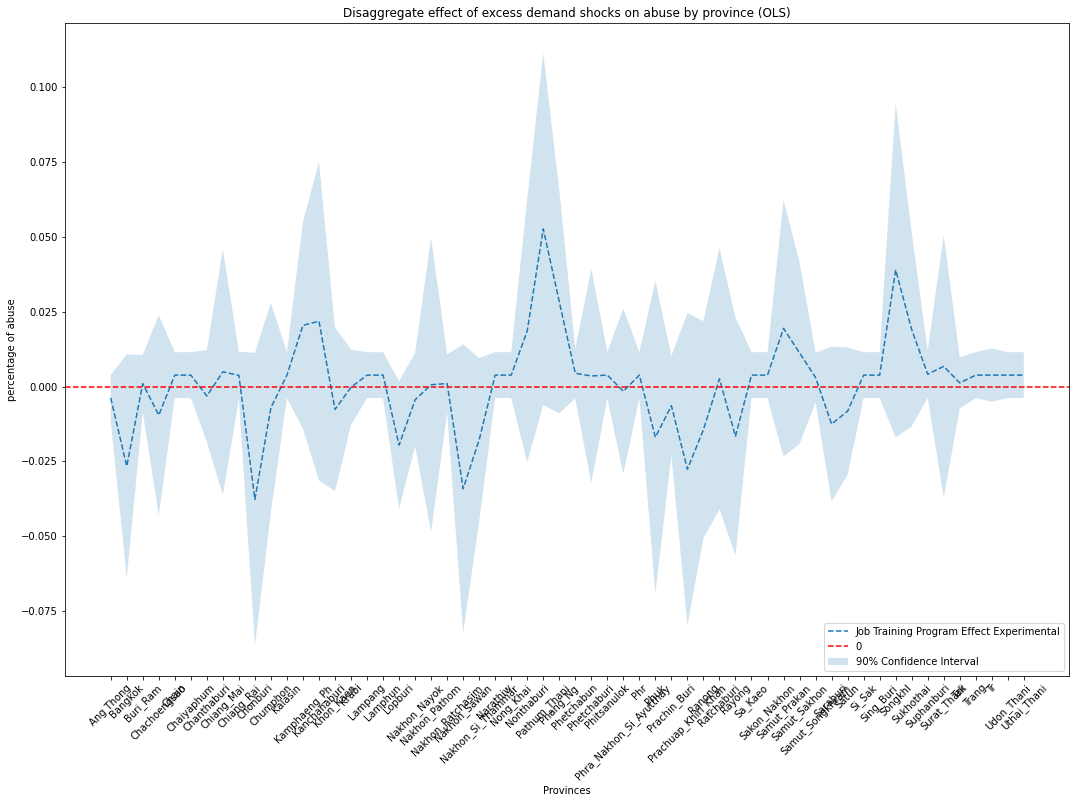

In [19]:
# Compare the estimate and the truth
plt.figure(figsize=(18, 12))
X_pos = np.arange(hte_data.shape[0])
plt.plot(X_pos, hte_data['effects'], "--", label="Job Training Program Effect Experimental")
plt.xticks(X_pos, hte_data['names'], rotation=45)
plt.fill_between(
    X_pos,
    hte_data['CI lower'],
    hte_data['CI upper'],
    alpha=0.2,
    label="90% Confidence Interval",
)
plt.axhline(c='red', ls='--', label='0')
plt.xlabel("Provinces")
plt.ylabel("percentage of abuse")
plt.title("Disaggregate effect of excess demand shocks on abuse by province (OLS)")
plt.legend(loc="lower right")
plt.savefig(plot_dir+'ols_province_effect.png')
plt.show()

# HTE by size of province demand

In [26]:
reg_data_notnull.province_size.min(), reg_data_notnull.province_size.max()

(0.04424778761061947, 747.7256637168143)

In [27]:
X_test = np.linspace(reg_data_notnull.province_size.min(), reg_data_notnull.province_size.max(), 20).reshape(-1, 1)
X_test

array([[4.42477876e-02],
       [3.93959013e+01],
       [7.87475547e+01],
       [1.18099208e+02],
       [1.57450862e+02],
       [1.96802515e+02],
       [2.36154169e+02],
       [2.75505822e+02],
       [3.14857476e+02],
       [3.54209129e+02],
       [3.93560782e+02],
       [4.32912436e+02],
       [4.72264089e+02],
       [5.11615743e+02],
       [5.50967396e+02],
       [5.90319050e+02],
       [6.29670703e+02],
       [6.69022357e+02],
       [7.08374010e+02],
       [7.47725664e+02]])

In [23]:
x_columns = ['demand_shock']
y_column = 'perc_abuse'

W = pd.get_dummies(reg_data_notnull['province'])
X = reg_data_notnull[['province_size']]
T = reg_data_notnull[x_columns]
# X = pd.concat([X, province_dummies], axis=1) 
# X = sm.add_constant(X)
Y = reg_data_notnull[y_column]

est = LinearDML(model_t=RandomForestRegressor(min_samples_leaf=5),\
                model_y=RandomForestRegressor(min_samples_leaf=5), discrete_treatment=False)
est.fit(Y, T, X=X, W=W)
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)
# print summary
est.summary()

/usr/local/lib/python3.7/site-packages/econml/utilities.py:821: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
/usr/local/lib/python3.7/site-packages/econml/utilities.py:821: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,0.0,0.0,0.174,0.862,-0.0,0.0
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.004,0.002,-2.254,0.024,-0.007,-0.001


In [24]:
from econml.dml import ForestDML
from sklearn.ensemble import GradientBoostingRegressor
est = ForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor())

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_di

/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: inval

/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/usr/local/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value en

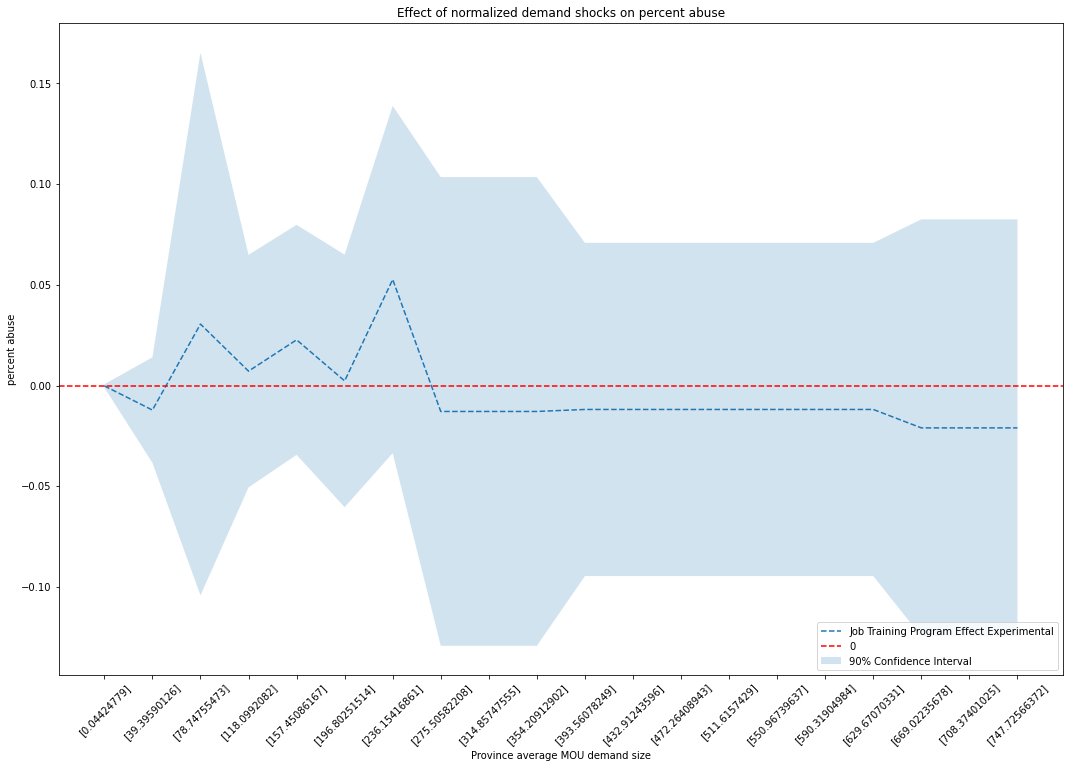

In [28]:
est.fit(Y, T, X=X, W=W)
dml_effects = est.effect(X_test)
dml_ci = est.effect_interval(X_test, alpha=0.05)

# Compare the estimate and the truth
plt.figure(figsize=(18, 12))
X_pos = np.arange(X_test.shape[0])
plt.plot(X_pos, dml_effects, "--", label="Job Training Program Effect Experimental")
plt.xticks(X_pos, X_test.ravel(), rotation=45)
plt.fill_between(
    X_pos,
    dml_ci[0].ravel(),
    dml_ci[1].ravel(),
    alpha=0.2,
    label="90% Confidence Interval",
)
plt.axhline(c='red', ls='--', label='0')
plt.xlabel("Province average MOU demand size")
plt.ylabel("percent abuse")
plt.title("Effect of normalized demand shocks on percent abuse")
plt.legend(loc="lower right")
plt.show()